In [1]:
!python -m pip install mpi4py

/usr/bin/python: No module named pip


In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
arr = 6.3 * np.random.randn(10) + 4.5
arr

array([-3.73470013, -7.79492896,  3.91612171, -2.18900153, 13.79265676,
       10.80223549,  3.37854159,  6.87322831,  8.86435768,  2.59879221])

In [4]:
def seqBubbleSort(arr):
  
  for i in range(len(arr)):
    
    for j in range(i+1, len(arr)):
      
      if arr[i] > arr[j]:
        arr[i], arr[j] = arr[j], arr[i]
  
  return arr

In [5]:
seqBubbleSort(arr)

array([-7.79492896, -3.73470013, -2.18900153,  2.59879221,  3.37854159,
        3.91612171,  6.87322831,  8.86435768, 10.80223549, 13.79265676])

In [6]:
import timeit

timeit.timeit(setup="from __main__ import seqBubbleSort, arr", stmt='seqBubbleSort(arr)', number=100)

0.002149031002772972

In [7]:
seq_times = []
seq_sizes = []

for n in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
  
  arr = 6.3 * np.random.randn(n) + 4.5

  tt = timeit.timeit(setup="from __main__ import seqBubbleSort, arr", stmt='seqBubbleSort(arr)', number=100)
  
  seq_times.append(tt)
  seq_sizes.append(n)

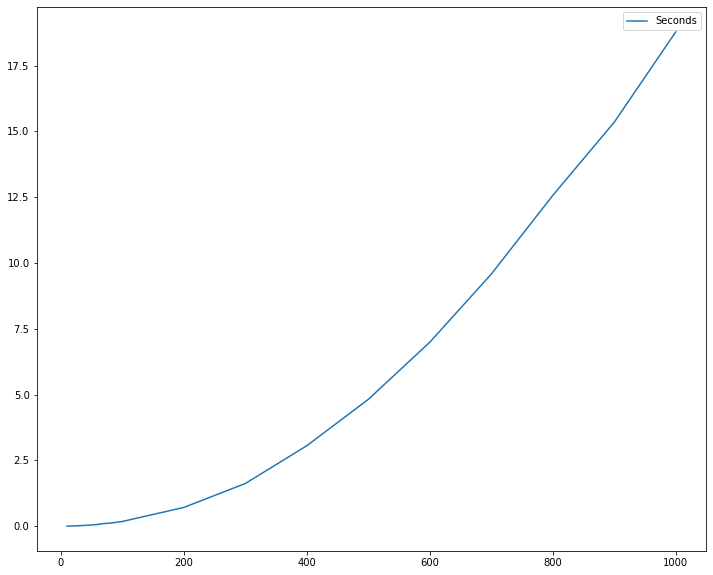

In [8]:
fig = plt.figure(figsize=(12, 10))
plt.plot(seq_sizes, seq_times, label='Seconds')
plt.legend()
plt.show();

In [9]:
def parallelBubbleSort(arr):

  n = len(arr)
  for k in range(n-1):
    if k % 2 == 0:
      for i in range(n//2 - 0):
        if arr[2*i] > arr[2*i+1]:
          arr[2*i], arr[2*i+1] = arr[2*i+1], arr[2*i]
    else:
      for i in range(n//2 - 1):
        if arr[2*i+1] > arr[2*i+2]:
          arr[2*i+1], arr[2*i+2] = arr[2*i+2], arr[2*i+1]

  return arr

arr = 6.3 * np.random.randn(10) + 4.5
parallelBubbleSort(arr)

array([-5.44660977,  4.7121926 ,  5.15176152,  7.08733035,  7.18971628,
        7.4059209 ,  8.4714126 ,  8.76514391,  9.1520177 ,  9.64770534])

In [10]:
import multiprocessing as mp
import numpy as np


num_cores = mp.cpu_count()

arr = np.random.randint(low=-100, high=100, size=10)
mem_mgr = mp.Manager()
shared_arr = mem_mgr.list(arr)

def processEven(i):
  global shared_arr
  if shared_arr[2*i] > shared_arr[2*i+1]:
    shared_arr[2*i], shared_arr[2*i+1] = shared_arr[2*i+1], shared_arr[2*i]


def processOdd(i):
  global shared_arr
  if shared_arr[2*i+1] > shared_arr[2*i+2]:
    shared_arr[2*i+1], shared_arr[2*i+2] = shared_arr[2*i+2], shared_arr[2*i+1]


def mpBubbleSort(n, p):
  for k in range(n):
    if k % 2 == 0:
      p.map(processEven, [i for i in range(n//2 - 0)])
    else:
      p.map(processOdd, [i for i in range(n//2 - 1)])

p = mp.Pool(num_cores)
mpBubbleSort(len(arr), p)
p.close()
print('original array \t', arr)
print('sorted array \t', shared_arr)

original array 	 [ 90 -49 -78 -27  85 -95  26 -76 -90  24]
sorted array 	 [-95, -90, -78, -76, -49, -27, 24, 26, 85, 90]


In [11]:
seq_times = []
par_times = []
mp_times = []
sizes = []

for n in range(10, 501, 10):

  arr = 6.3 * np.random.randn(n) + 4.5
  mem_mgr = mp.Manager()
  shared_arr = mem_mgr.list(arr)
  p = mp.Pool(num_cores)

  tt_seq = timeit.timeit(setup="from __main__ import seqBubbleSort, arr", stmt='seqBubbleSort(arr)', number=1)
  tt_par = timeit.timeit(setup="from __main__ import parallelBubbleSort, arr", stmt='parallelBubbleSort(arr)', number=1)
  tt_mp = timeit.timeit(
      setup="from __main__ import mpBubbleSort, n, p", stmt='mpBubbleSort(n, p)', number=1)
  
  p.close()
    
  seq_times.append(tt_seq)
  par_times.append(tt_par)
  mp_times.append(tt_mp)
  sizes.append(n)


Process ForkPoolWorker-455:
Process ForkPoolWorker-452:
Process ForkPoolWorker-458:
Traceback (most recent call last):
Process ForkPoolWorker-454:
Traceback (most recent call last):
Process ForkPoolWorker-457:
Traceback (most recent call last):
Process ForkPoolWorker-456:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-459:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-453:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    ret

  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(12, 10))
plt.plot(sizes, seq_times, label='Bubble Sort Seconds', c='b')
plt.plot(sizes, par_times, label='Odd Even Transpose Seconds', c='g')
plt.legend()
plt.show();

In [ ]:
fig = plt.figure(figsize=(12, 10))
plt.plot(sizes, seq_times, label='Bubble Sort Seconds', c='b')
plt.plot(sizes, par_times, label='Odd Even Transpose Seconds', c='g')
plt.plot(sizes, mp_times, label='Parallel(p=2) Odd Even Transpose Seconds', c='k')
plt.legend()
plt.show();

In [ ]:
avg = 0

for i, j in zip(seq_times, par_times):
  avg += abs(j - i) / j
 
avg = avg / len(seq_times)

print("Overall Improvement (Bubble Sort vs Odd-Even Transpose): %{:0.2f}".format(avg * 100))

In [ ]:
mp_4_times = []
mp_8_times = []
mp_10_times = []

sizes = []

for n in range(10, 501, 10):

  arr = 6.3 * np.random.randn(n) + 4.5
  mem_mgr = mp.Manager()
  shared_arr = mem_mgr.list(arr)
  p_4 = mp.Pool(4)
  p_8 = mp.Pool(8)
  p_10 = mp.Pool(16)

  tt_mp_4 = timeit.timeit(
      setup="from __main__ import mpBubbleSort, n, p_4", stmt='mpBubbleSort(n, p_4)', number=1
      )
  tt_mp_8 = timeit.timeit(
      setup="from __main__ import mpBubbleSort, n, p_8", stmt='mpBubbleSort(n, p_8)', number=1
      )
  tt_mp_10 = timeit.timeit(
      setup="from __main__ import mpBubbleSort, n, p_10", stmt='mpBubbleSort(n, p_10)', number=1
      )

  p_4.close()
  p_8.close()
  p_10.close()

  mp_4_times.append(tt_mp_4)
  mp_8_times.append(tt_mp_8)
  mp_10_times.append(tt_mp_10)
  sizes.append(n)


In [ ]:
fig = plt.figure(figsize=(12, 10))
plt.plot(sizes, mp_4, label='(P=4) Seconds', c='y')
plt.plot(sizes, mp_8, label='(P=8) Seconds', c='c')
plt.plot(sizes, mp_10, label='(P=10) Seconds', c='l')
plt.legend()
plt.show();

In [ ]:
fig = plt.figure(figsize=(12, 10))
plt.plot(sizes, seq_times, label='Bubble Sort Seconds', c='b')
plt.plot(sizes, par_times, label='Odd Even Transpose Seconds', c='g')
plt.plot(sizes, mp_times, label='Parallel(P=2) Odd Even Transpose Seconds', c='k')
plt.plot(sizes, mp_4, label='Parallel(P=4) Seconds', c='y')
plt.plot(sizes, mp_8, label='Parallel(P=8) Seconds', c='c')
plt.plot(sizes, mp_10, label='Parallel(P=10) Seconds', c='l')
plt.legend()
plt.show();

**Hardware & Software Specifications**

In [ ]:
!apt-get install hwinfo

In [ ]:
!hwinfo

In [ ]:
!python -V

In [ ]:
!pip freeze